In [3]:
import B2D
import bitsetting
import numpy as np
import random
from skimage import io,transform
from matplotlib import pyplot as plt
from xxhash import xxh32

In [4]:
def APPM_RT256():
    RT = []
    for i in range(256):
        row = []
        count = (i*60)%256
        for j in range(256):
            row.append(count)
            count += 1
            if count >= 256:
                count -= 256
        RT.append(row)
    RT = np.array(RT)
    return RT

In [4]:
def APPM_RT64():
    RT = []
    for i in range(256):
        row = []
        count = (i*14)%64
        for j in range(256):
            row.append(count)
            count += 1
            if count >= 64:
                count -= 64
        RT.append(row)
    RT = np.array(RT)
    return RT

In [5]:
class Queue():
    def __init__(self):
        self.q = []
        self.r = -1
    def reset(self):
        self.q = []
        self.r = -1    
    def enqueue(self,r,c):
        self.q.append((r,c))
    def dequeue(self):
        self.r += 1
        if self.r >= len(self.q):
            return False
        return self.q[self.r]

In [6]:
def BFS(RT,r,c,g):
    Q = Queue()
    Q.enqueue(r,c)
    F = np.full((RT.shape[0],RT.shape[1]),False,dtype=bool)
    F[r,c] = True
    while True:
        k = Q.dequeue()
        if k == False:
            break
        if RT[k[0],k[1]] == g:
                return k
        if k[0] != 0 and not F[k[0]-1,k[1]]:
            Q.enqueue(k[0]-1,k[1])
            F[k[0]-1,k[1]] = True
        if k[0] != RT.shape[0]-1 and not F[k[0]+1,k[1]]:
            Q.enqueue(k[0]+1,k[1]) 
            F[k[0]+1,k[1]] = True
        if k[1] != 0 and not F[k[0],k[1]-1]:
            Q.enqueue(k[0],k[1]-1)
            F[k[0],k[1]-1] = True
        if k[1] != RT.shape[1]-1 and not F[k[0],k[1]+1]:
            Q.enqueue(k[0],k[1]+1)  
            F[k[0],k[1]+1] = True  



In [7]:
def hashB(npArray,bits):
    return np.mod(xxh32(npArray).intdigest(), 2**bits)

In [8]:
def fold(arr,bit):
    k = B2D.Dec2Bin(arr)
    l = len(k)
    while(l > bit):
        l >>= 1
        a = k[:l]
        b = k[l:]
        k = []
        for i in range(l):
            k.append(a[i]^b[i])
    return B2D.Bin2Dec(k)

In [9]:
def bb_tol(Gray,Gray2,G1,G2):
    base = round(Gray)
    low_tol = Gray - (base - 0.5) + (255 - G1) * 0.587
    up_tol = (base + 0.5) - Gray + (G1) *0.587
    blue_low_tol = int(low_tol/0.114)
    blue_up_tol = int(up_tol/0.114)

    base2 = round(Gray2)
    low_tol = Gray2 - (base2 - 0.5) + (255 - G2) * 0.587
    up_tol = (base2 + 0.5) - Gray2 + (G2) *0.587
    blue2_low_tol = int(low_tol/0.114)
    blue2_up_tol = int(up_tol/0.114)
    
    # print(low_tol,base,Green)

    return np.array([blue_low_tol,blue2_low_tol,blue_up_tol,blue2_up_tol])


In [11]:
def rb_tol(Gray,Green):
    base = round(Gray)
    low_tol = Gray - (base - 0.5) + (255 - Green) * 0.587
    up_tol = (base + 0.5) - Gray + (Green) *0.587
    red_low_tol = int(low_tol/0.299)
    blue_low_tol = int(low_tol/0.114)
    red_up_tol = int(up_tol/0.299)
    blue_up_tol = int(up_tol/0.114)


    # print(low_tol,base,Green)

    return np.array([red_low_tol,blue_low_tol,red_up_tol,blue_up_tol])

In [12]:
def limit(R,B):
    R = R >> 5
    R = R << 5
    UR = R + 31
    LR = R

    B = B >> 5
    B = B << 5
    UB = B + 31
    LB = B

    return np.array([LR,LB,UR,UB])

In [12]:
def perturbed(r,g,a):
    possible = []
    for i in range(-1*a,a):
        for j in range(-1*a,a):
            if(not (r+i < 0 or r+i > 255 or g+j < 0 or g+j > 255)):
                possible.append([r+i,g+j])
    return np.array(possible)

In [13]:
def noise(I,Noise):
    n_r,n_c = Noise.shape[0],Noise.shape[1]

    for i in range(n_r):
        for j in range(n_c):
            if(Noise[i, j,3]==0):
                continue
            for k in range(3):
                I[i,j,k] = Noise[i,j,k]

    return I

In [13]:
def remedy(r,g,b,ac):
    Gray = round(r*0.299+g*0.587+b*0.114)
    rg_poss = perturbed(r,g,2)
    b_poss = []
    origin_b = b
    b >>= 2
    b <<= 2
    for i in range(-1,2):
        if(b + i*4 >= 0 and b + i*4 <= 255):
            b_poss.append(b + i*4)

    b_poss = np.array(b_poss)

    tar = None
    distance = np.inf
    for i in range(len(rg_poss)):
        for j in range(len(b_poss)):
            # print(rg_poss[i,0],rg_poss[i,1])
            if(Gray == round(rg_poss[i,0]*0.299+rg_poss[i,1]*0.587+b_poss[j]*0.114) and
               Gray == round(rg_poss[i,0]*0.299+rg_poss[i,1]*0.587+(b_poss[j]+3)*0.114)):
                b_poss[j] >>= 2
                b_poss[j] <<= 2
                b_poss[j] += ac
                
                new_d = ((rg_poss[i,0]-r)**2 + (rg_poss[i,1]-g)**2 + (b_poss[j]-origin_b)**2)**0.5

                if(new_d < distance):
                    distance = new_d
                    tar = [rg_poss[i,0],rg_poss[i,1],b_poss[j]]

    return tar

In [14]:
def AVGI(Graph):
    path = 'image/'+Graph
    I=io.imread(path +r'.tiff')
    Stego = I.copy()
    RT = APPM_RT256()

    p = 0
    MSE = 0
    F = 0
    N = 0
    X = 0

    # print(Stego.shape[0],Stego.shape[1],Stego.shape[2])

    for i in range(Stego.shape[0]):
        for j in range(Stego.shape[1]):
            Gray = I[i,j,0]*0.299+I[i,j,1]*0.587+I[i,j,2]*0.114
            G_round = round(Gray)
            ac = G_round    
            
            k = BFS(RT,Stego[i,j,0],Stego[i,j,2],ac)          

            # print(f"i: {i} j: {j} k:{k}")
            # print(Stego[i,j,2],Stego[i,j+1,2],k)
            # print(f"i: {i}, j: {j}, I:({I[i,j,0]},{I[i,j,2]}), k:{k}")

            Stego[i,j,0] = k[0]
            Stego[i,j,2] = k[1]  
            g_bar = int((Gray - 0.299*k[0] - 0.114*k[1])/0.587)
            if(round(0.299*k[0]+0.587*g_bar+0.114*k[1]) < round(Gray)):
                g_bar += 1
            elif(round(0.299*k[0]+0.587*g_bar+0.114*k[1]) > round(Gray)):
                g_bar -= 1

            if(g_bar > 255):
                p += 1
                g_bar = 255
            elif(g_bar < 0):
                p += 1
                g_bar = 0
                
            Stego[i,j,1] = g_bar

            # print(f"I:{I[i,j]}, S:{Stego[i,j]}, g_bar:{(Gray - 0.299*k[0] - 0.114*k[1])/0.587}, k:{k}")

            delta = int(Stego[i,j,2]) - int(I[i,j,2])
            if(delta > 8):
                X += 1
            MSE += delta ** 2
            delta = int(Stego[i,j,1]) - int(I[i,j,1])
            if(delta > 8):
                X += 1
            MSE += delta ** 2 
            delta = int(Stego[i,j,0]) - int(I[i,j,0])
            if(delta > 8):
                X += 1            
            MSE += delta ** 2                                        

    MSE /= (Stego.shape[0]*Stego.shape[1]*3)
    PSNR = 10 * np.log10(65025/MSE)
    print(f"PSNR:{PSNR} , F:{p} , X:{X}")

    with open("processing_data/"+Graph+".txt","w") as file:
        file.write(f"PSNR: {PSNR}\n")
        file.write(f"outliers: {p}")


    io.imshow(Stego)
    io.show()
    io.imsave('processing_image/'+Graph+'.png',Stego)

In [30]:
def Authorize(Graph):
    path = "embeding_noise/"+Graph+".png"

    I=io.imread(path)
    Stego = I.copy()
    RT = APPM_RT256()
    print(Stego.shape[2])
    Flag = False

    for i in range(Stego.shape[0]):
        # if(Flag):
        #     break
        for j in range(Stego.shape[1]):
            Gray = I[i,j,0]*0.299+I[i,j,1]*0.587+I[i,j,2]*0.114
            G_round = round(Gray)
            ac = G_round
    
            if(ac > RT[Stego[i,j,0],Stego[i,j,2]] and Stego[i,j,1] != 0):
                Stego[i,j,0] = 255
                Stego[i,j,1] = 255
                Stego[i,j,2] = 255
                # print(f"This picture is tampered. i: {i} ,j: {j} ,Stego:{Stego[i,j]} ,Gray:{Gray}, RT:{RT[Stego[i,j,0],Stego[i,j,2]]}")
                # Flag = True
                # break 
            elif(ac < RT[Stego[i,j,0],Stego[i,j,2]] and Stego[i,j,1] != 255):
                Stego[i,j,0] = 255
                Stego[i,j,1] = 255
                Stego[i,j,2] = 255
                # print(f"This picture is tampered. i: {i} ,j: {j} ,Stego:{Stego[i,j]} ,Gray:{Gray}, RT:{RT[Stego[i,j,0],Stego[i,j,2]]}")
                # Flag = True
                # break  
            else:
                Stego[i,j,0] = 0
                Stego[i,j,1] = 0
                Stego[i,j,2] = 0
    io.imshow(Stego, vmin=0, vmax=255)
     
    plt.show()  # 不调用 tight_layout
    # if(not Flag):
    #     print("This picture is not tampered.")

              

In [16]:
def embeding(image,n):
    path = "processing_image/"+image+".png"
    I=io.imread(path)
    path2 = "noise/"+n+".png"
    I2=io.imread(path2)

    print(I2[0,0])
    print(I2[4,25])
    e = noise(I,I2)

    io.imshow(e)
    io.imsave('embeding_noise/'+image+'.png',e)     

PSNR:35.89838870638283 , F:8236 , X:17681


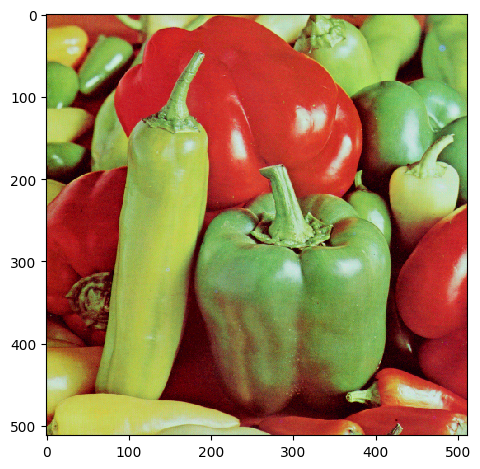

In [52]:
AVGI('Peppers')

[0 0 0 0]
[0 0 0 0]


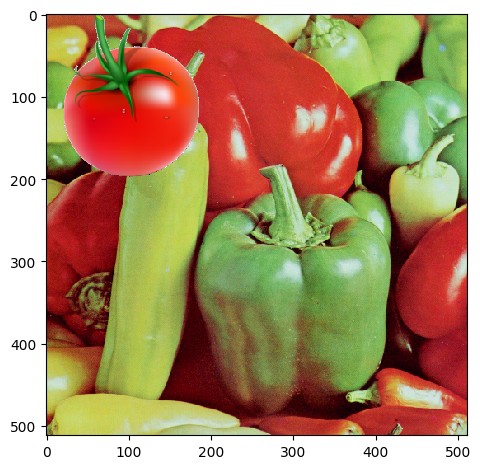

In [32]:
embeding("Peppers","tomato")

3


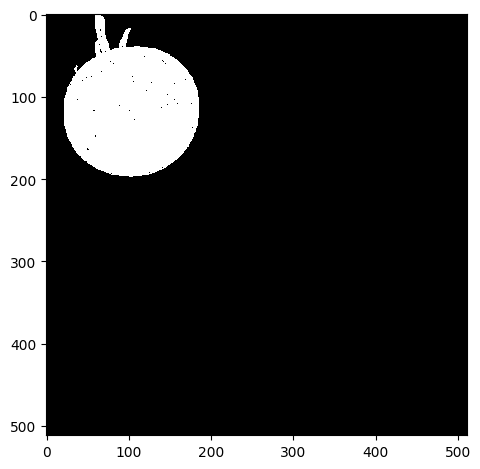

In [33]:
Authorize('Peppers')
# path = 'image/Peppers'
# I=io.imread(path +r'.tiff')
# RT = APPM_RT256()
# i = 32
# j = 456
# Gray = I[i,j,0]*0.299+I[i,j,1]*0.587+I[i,j,2]*0.114

# G_round = round(Gray)
# ac = G_round


# g_bar = int((Gray - 0.299*47 - 0.114*9)/0.587)
# print(g_bar)
# print(I[i,j,0],I[i,j,1],I[i,j,2],Gray,RT[I[i,j,0],I[i,j,2]])

# print()

In [18]:
# path = 'image/Peppers'
# i = 23
# j = 0
# I=io.imread(path +r'.tiff')
# RT = APPM_RT256()
# Gray = I[i,j,0]*0.299+I[i,j,1]*0.587+I[i,j,2]*0.114

# G_round = round(Gray)
# ac = hashB(np.array([G_round]),8)  
# num = fold(ac,2)

# g_bar = int(round((Gray - 0.299*68 - 0.114*57)/0.587))
# print(g_bar,(Gray - 0.299*68 - 0.114*57)/0.587)
# print(I[i,j,0],I[i,j,1],I[i,j,2],Gray)
# print(ac,num)
# print(remedy(I[i,j,0],I[i,j,1],I[i,j,2],num))